# Project 3: 探索数据集--未前往就诊的挂号预约分析
 
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> 本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。其中最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。
>本次分析病人能否按时就诊的主要因素包括：
><ul>
><li>病人预约的时间；</li>
><li>病人的年龄、性别；</li>
><li>病人是否慢性病患者、酗酒或残疾；</li>
><li>在提供短信提醒的情况下，病人按时就诊的概率是否提高。尤其对于预约时间间隔特别长的病人来说，短信提醒是否有所帮助。</li>

In [69]:
# load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('hls',10))

<a id='wrangling'></a>
## Data Wrangling



### 1. 导入dataset，检查数据基本属性

In [70]:
# load data
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


**打印数据info发现dataset共有110527行，13列，没有NaN值。**

### 2. 修改列名、数据格式

In [71]:
# 重命名拼写错误、有破折号和下划线的列
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [72]:
#转换成时间格式
df.ScheduledDay=pd.to_datetime(df.ScheduledDay)
df.AppointmentDay=pd.to_datetime(df.AppointmentDay)
#将PatientId从float修改为int
df['PatientId'] = df['PatientId'].astype('int64')
#检查是否修改成功
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


### 3. 删除奇异值

In [73]:
#检查数据内容
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


**检查发现Age的最小值为-1，应删除；  
    Age的最大值为115，Handicap的最大值为4，需打印确认数据是否合理；** 

In [74]:
#参看超过100岁的病人数据
df.query('Age>100')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
58014,976294799775439,5651757,F,2016-05-03 09:14:53,2016-05-03,102,CONQUISTA,0,0,0,0,0,0,No
63912,31963211613981,5700278,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,31963211613981,5700279,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,31963211613981,5562812,F,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,31963211613981,5744037,F,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,No
90372,234283596548,5751563,F,2016-05-31 10:19:49,2016-06-02,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,748234579244724,5717451,F,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,No


**115岁的老人预约共有5次，其中4次为同一个人（3次爽约、1次赴约），可信度较高，不做处理。下面仅删除年龄小于0岁的病人数据。**

In [75]:
#删除小于0岁的病人。
df=df[(df.Age>=0)]

In [76]:
#查看Handicap的值分类
df['Handicap'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: Handicap, dtype: int64

**残障分为1-4钟不同类型或程度，由于文档没有相关数据描述，本次分析将0视为无残疾，1-4为残疾的不同程度。**

In [77]:
#计算整体误诊率
total_ratio=df[df.NoShow == 'Yes'].shape[0]/df.shape[0]
print("In total,{:.2%} of people didn't show up on their appointment.".format(total_ratio))

In total,20.19% of people didn't show up on their appointment.


<a id='eda'></a>
## Exploratory Data Analysis



### Q1: 病人的预约时间对按时就诊率的影响

In [78]:
# 计算Scheduled day 与 appointment day之间的日期间隔
df['duration']=df.AppointmentDay.dt.date-df.ScheduledDay.dt.date
df['duration']=df['duration'].dt.days

In [79]:
# 查看appointment day 是星期几
df['weekday']=df.AppointmentDay.dt.weekday_name
df.head()
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,duration
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,10.183794
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,15.255034
min,3.921700e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


**duration的最小值小于0，即存在预定的日期已经在安排日期之前的情况。**

In [80]:
# 查看duration<0的数据行
df[df['duration']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,duration,weekday
27033,7839272661752,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1,Monday
55226,7896293967868,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1,Tuesday
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1,Wednesday
71533,998231581612122,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6,Thursday
72362,3787481966821,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1,Tuesday


**共存在6行此类数据，No Show为yes，说明因预约日期有误，病人无法如期就诊，下面删除这6行数据。**

In [81]:
df=df[df['duration']>=0]
#检查是否删除了6行数据
df.shape

(110521, 16)

#### （1）工作日和周末对no-show rate的影响

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

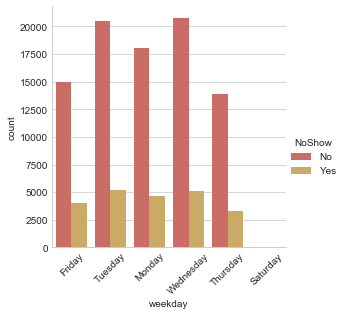

In [82]:
#分类查看周一到周日的到诊量
sns.factorplot("weekday",data=df,hue="NoShow",kind="count")
plt.xticks(rotation=45)

**bar plot上周六因预约数过少，无法看清比例；且横坐标没有周日。下面计算周一到周日的爽约比例。**

In [83]:
#该函数用于计算分类比率
def ratio(item):
    return df[df.NoShow == 'Yes'].groupby(item).size()/df.groupby(item).size()

weekday
Friday       0.212261
Monday       0.206446
Saturday     0.230769
Thursday     0.193494
Tuesday      0.200874
Wednesday    0.196861
dtype: float64


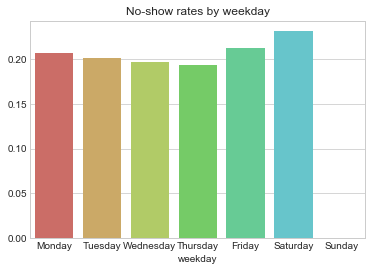

In [84]:
#计算误诊率
weekday_ratio=ratio('weekday')
fig=sns.barplot(x=weekday_ratio.index, y=weekday_ratio, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.set_title("No-show rates by weekday")
print(weekday_ratio)

**从上图可以看出：  
周一到周五的误诊率都在20%左右，与整体误诊率一致。周六的误诊率最高，达到23%；  
周六的预约量极少，周日无预约，可能因为大部分医院不接受周末的预约。  
综合来看，weekday并不适合用来判断病人能否按时就诊。**

#### （2） 安排日期和预定日期之间的时间间隔对到诊率的影响

一般来说，预约当天就诊的病人应当会如期就诊，下面验证这一推测：

In [85]:
df[df.NoShow == 'Yes'].groupby(['duration']).size()[0]/(df.groupby(['duration']).size()[0])

0.046470618743841084

**仅有4.67%的人会在预约当天看病的情况下爽约，这一比例大大小于总体爽约率（20%）**

In [86]:
len(df['duration'].unique())

129

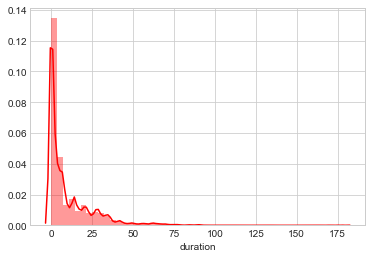

In [87]:
#检查duration的取值范围和分布：
sns.distplot(df['duration'], color="r")

**duration主要集中在0-25天，但因其取值范围过大，下面对duration进行分类：**

In [88]:
bin_edges = [-1,0,4,15,30,180 ]
bin_names = ["0 day", "1-4 days", "5-15 days","16-30 days",">1 month" ]
df['duration_group'] = pd.cut(df['duration'], bin_edges, labels=bin_names)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

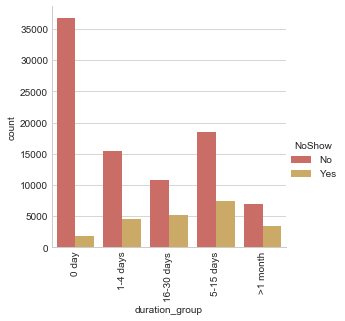

In [89]:
sns.factorplot("duration_group",data=df,hue="NoShow",kind="count")
plt.xticks(rotation=90)

**上图可以看出，预约当天就诊的人数超过35000人，约占总样本量的1/3。且随着预约日期的延后，爽约率逐步增加。  
下面计算这一比值：**

duration_group
0 day         0.046471
1-4 days      0.229902
5-15 days     0.285381
16-30 days    0.325120
>1 month      0.330025
dtype: float64


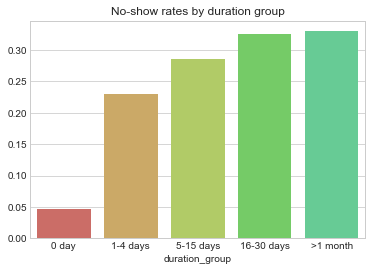

In [90]:
#计算每个时间段的实际比值
ind=["0 day", "1-4 days", "5-15 days","16-30 days",">1 month" ]
duration_ratio=df[df.NoShow == 'Yes'].groupby(['duration_group']).size()/df.groupby(['duration_group']).size()

fig=sns.barplot(x=duration_ratio.index, y=duration_ratio, order=ind)
fig.set_title("No-show rates by duration group")
print(duration_ratio.reindex(ind))

**结论：仅有4.67%的人会在预约当天看病的情况下爽约；在scheduel day的5天后看诊的爽约率（28%-32%）极大的超出了总体爽约率（20%）。因此这一指标可以用于判断病人是否能够按时赴约。**

### Q2: 病人的性别、年龄对按时就诊率的影响  
  
  #### （1）性别因素

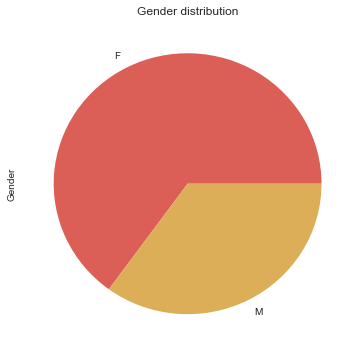

In [107]:
#dataset的性别分布
df['Gender'].value_counts().plot(kind='pie',figsize=(6,6))
plt.title("Gender distribution")

女性病患的数量是男性病患的近2倍，可能女性更注重自身的健康状况。

In [92]:
#按性别计算爽约率
ratio('Gender')

Gender
F    0.203115
M    0.199638
dtype: float64

**结论：男女病患的爽约率基本一致，且与总体爽约情况一致。故性别无法判断病人是否按照到诊。**  
  
#### （2）年龄因素

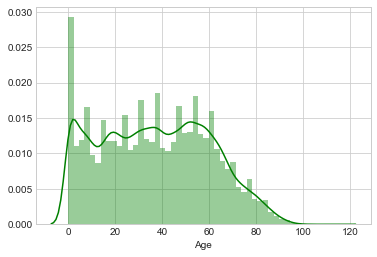

In [93]:
#查看年龄分布
sns.distplot(df['Age'], color="g")

**因样本数据的年龄跨度大，不适合分别计算爽约率，下面将年龄进行分组计算。**

In [94]:
#年龄分组
bin_edges = [-1,10,18,37,55,102 ]
bin_names = ["<=10", "11-18", "19-37","38-55",">55" ]
df['age_group'] = pd.cut(df['Age'], bin_edges, labels=bin_names)

In [95]:
#计算爽约比例
age_ratio=ratio('age_group')
age_ratio

age_group
11-18    0.252941
19-37    0.235320
38-55    0.195280
<=10     0.201995
>55      0.156339
dtype: float64

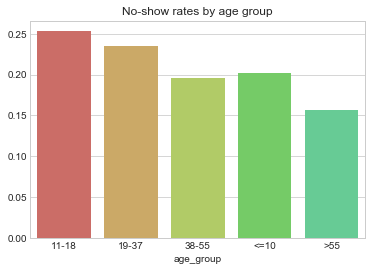

In [96]:
#爽约比例绘图
fig=sns.barplot(x=age_ratio.index, y=age_ratio)
fig.set_title("No-show rates by age group")

**结论：**<ul>
<li>11-18岁的病人的爽约率最高（25.29%）；</li>
<li>10岁以下儿童、38-55岁成人的爽约率与总体爽约率保持一致；</li>
<li>55岁以上老人的爽约率最低（15.63%）。</li>

### Q3: 病人是否慢性病患者、酗酒或残疾对按时就诊率的影响  

#### （1）慢性病、酗酒情况

In [97]:
##爽约率计算
h_ratio=ratio('Hypertension')
d_ratio=ratio('Diabetes')
a_ratio=ratio('Alcoholism')
print(h_ratio)
print(d_ratio)
print(a_ratio)

Hypertension
0    0.208995
1    0.173020
dtype: float64
Diabetes
0    0.203591
1    0.180033
dtype: float64
Alcoholism
0    0.201911
1    0.201488
dtype: float64


(array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225]), <a list of 10 Text yticklabel objects>)

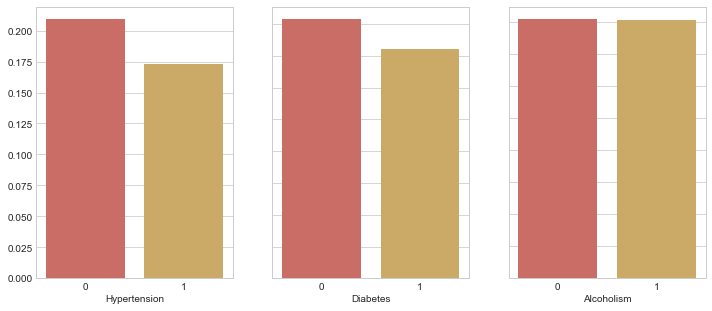

In [98]:
fig =plt.figure(figsize=(12, 5)) 
ax1=fig.add_subplot(131) 
sns.barplot(x=h_ratio.index, y=h_ratio)
ax2=fig.add_subplot(132) 
sns.barplot(x=d_ratio.index, y=d_ratio)
plt.yticks(visible=False)
ax3=fig.add_subplot(133) 
sns.barplot(x=a_ratio.index, y=a_ratio)
plt.yticks(visible=False)

**结论：**
<ul>
<li>慢性病患者（高血压、糖尿病）的爽约率约为18%，低于未患慢性病的病人。因此是否患有高血压或糖尿病可以作为判断病患是否按时赴约的因素。</li>
<li>是否酗酒对能否按时赴约没有影响,不能作为判断条件。</li>

#### （2）残疾情况

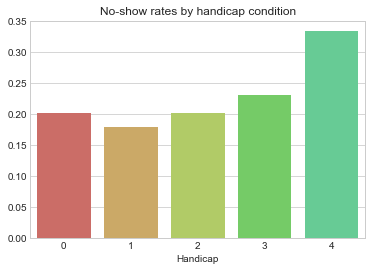

In [99]:
handicap_ratio=ratio('Handicap')
fig=sns.barplot(x=handicap_ratio.index, y=handicap_ratio)
fig.set_title("No-show rates by handicap condition")

**结论：该dataset中，残疾程度3级以上的病患爽约率更高。**

### Q4: 短信提醒对按时就诊率的影响  
  
 #### （1）短信提醒情况

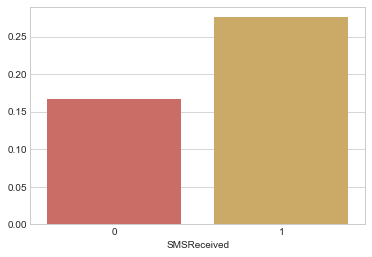

In [100]:
SMS_ratio=ratio('SMSReceived')
fig=sns.barplot(x=SMS_ratio.index, y=SMS_ratio)

**收到短信提醒的病人的爽约率大大高于未收到短信提醒的病人，这个调查结果不符合常识。下面再次检查收到短信的数据集**

In [101]:
#取出收到短信的数据行
SMS_sent=df.query('SMSReceived==1')
SMS_sent.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,duration
count,3.548200e+04,3.548200e+04,35482.000000,35482.000000,35482.000000,35482.000000,35482.000000,35482.000000,35482.0,35482.000000
mean,1.438652e+14,5.648697e+06,37.513810,0.098782,0.193619,0.066400,0.023871,0.016572,1.0,19.016713
std,2.518491e+14,8.066133e+04,22.330332,0.298374,0.395140,0.248983,0.152650,0.139882,0.0,16.978718
min,5.376150e+05,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000
25%,3.932647e+12,5.605518e+06,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,7.000000
50%,2.982433e+13,5.648944e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,14.000000
75%,9.358590e+13,5.716710e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,27.000000
max,9.999320e+14,5.773092e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.0,179.000000


**检查发现：收到短信的病人的预约时间间隔（duration）的最小值为3，而在前文已经指出有1/3的病人预约了当天就诊，即duration=0**

In [102]:
# 查看duration的唯一值
df.duration.unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  80,
        86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,  90,
       151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122, 101,
       105,  92,  97,  93, 107,  95, 139, 132, 179, 117, 146, 123], dtype=int64)

**可以看出，预约2天以内就诊的病人并不会收到短信提醒。为保证计算是否发送短信对赴约率影响的合理性，删除duration小于3的行。**

In [103]:
df_s=df.query('duration>2')
#再次计算爽约情况
sms=df_s[df_s.NoShow == 'Yes'].groupby(['SMSReceived']).size()/df_s.groupby(['SMSReceived']).size()
print(sms)

SMSReceived
0    0.326949
1    0.275745
dtype: float64


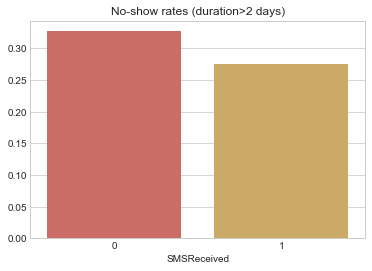

In [104]:
fig=sns.barplot(x=sms.index, y=sms)
fig.set_title("No-show rates (duration>2 days)")

**结论：给病患发送短息可以提高病患的赴约率。**

#### （2）短信提醒能否提高预约日期间隔长的病患的赴约率？

In [105]:
#前面已经取出了收到短信的用户数据，即SMS_sent。
#计算其按duration分组的爽约率。
sent_ratio=SMS_sent[SMS_sent.NoShow == 'Yes'].groupby(['duration_group']).size()/SMS_sent.groupby(['duration_group']).size()
print(sent_ratio)
print(duration_ratio)

duration_group
0 day              NaN
1-4 days      0.221970
16-30 days    0.296864
5-15 days     0.265549
>1 month      0.302028
dtype: float64
duration_group
0 day         0.046471
1-4 days      0.229902
16-30 days    0.325120
5-15 days     0.285381
>1 month      0.330025
dtype: float64


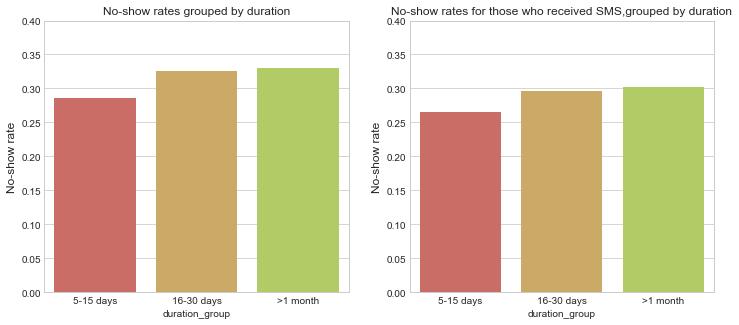

In [106]:
#将两张图进行对比。此处只选择duration>=5的duration groups进行比较
fig =plt.figure(figsize=(12, 5)) 
ax1=fig.add_subplot(121)
ax1.set_title("No-show rates grouped by duration")
sns.barplot(x=duration_ratio.reindex(ind).index[2:5], y=duration_ratio.reindex(ind)[2:5],).set(ylim=(0,0.4))
plt.ylabel('No-show rate', fontsize=12)
ax2=fig.add_subplot(122) 
sns.barplot(x=sent_ratio.reindex(ind).index[2:5], y=sent_ratio.reindex(ind)[2:5]).set(ylim=(0,0.4))
ax2.set_title("No-show rates for those who received SMS,grouped by duration")
plt.ylabel('No-show rate', fontsize=12)

**结论：在收到短信提醒的情况下，预约间隔长的病人的赴约率提高了2%。**

<a id='conclusions'></a>
## Conclusions
对11万条巴西病人按时赴诊数据的分析后，得出以下结论：
<ol>
<li>病人预约的时间：仅有4.67%的人会在预约当天看病的情况下爽约；在scheduel day的5天后看诊的爽约率（28%-32%）极大的超出了总体爽约率（20%）。而预约日是周几对病人赴约情况的影响不大。  </li>  

<li>病人的年龄、性别：男女患者的赴约就诊率基本一致，11-18岁的病人的爽约率最高（25.29%）；10岁以下儿童、38-55岁成人的爽约率与总体爽约率保持一致；55岁以上老人的爽约率最低（15.63%）。</li>  

<li>病人是否慢性病患者、酗酒或残疾: 慢性病患者（高血压、糖尿病）的爽约率约为18%，低于未患慢性病的病人。是否酗酒对能否按时赴约影响不大。</li>
<li>收到短信提醒的病人的按时就诊率高于未收到短信的病人。尤其对于预约时间间隔较长（大于5天）的病人来说，收到短信提醒后的赴约率比相应时间间隔的整体赴约率提高2个百分点。</li>

最后，由于数据样本在巴西各个地区（neighborhood）的sample size极不均衡，以上结论不能作为判断巴西全国病人按时到诊率的依据，亦不能作为世界其他国家病人到诊率的判断标准。